# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment4"
if not os.path.exists(datadir):
  !ln -s "/content/drive/MyDrive/path_to/assignment4" $datadir # TODO: Fill your Assignment 4 path
os.chdir(datadir)
!pwd

In [1]:
!git clone https://github.com/EeshaR/cs444

Cloning into 'cs444'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 261 (delta 59), reused 0 (delta 0), pack-reused 143
Receiving objects: 100% (261/261), 2.68 MiB | 29.53 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [2]:
import sys

# Add the path to the directory containing the `gan` package to sys.path
sys.path.append('/kaggle/working/cs444/assignment4')

# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [4]:
from gan.train import train
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss
from gan.utils import show_images

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


100%|██████████| 9912422/9912422 [00:00<00:00, 128630556.60it/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 48609828.98it/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 50046612.95it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 10231218.46it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



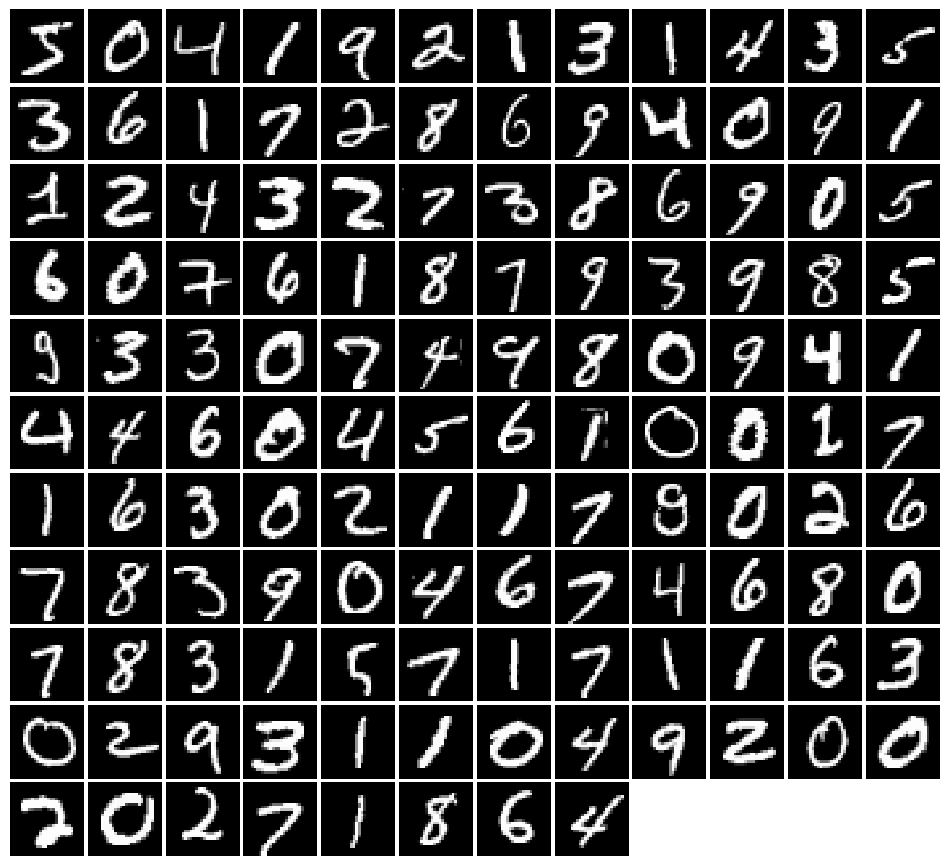

In [8]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)

try:
  imgs = next(iter(loader_train))[0].view(batch_size, 784).numpy().squeeze()
except:
  imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()

show_images(imgs)

# Discriminator and Generator


In [9]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [10]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [11]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 0.6933, G:0.7012


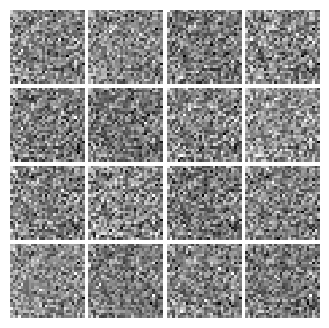


Iter: 250, D: 0.9046, G:2.447


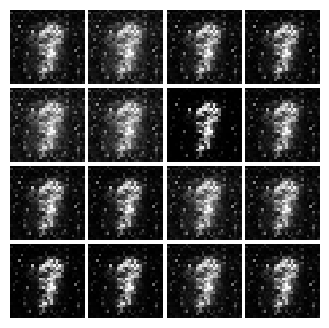


EPOCH:  2
Iter: 500, D: 0.5468, G:1.204


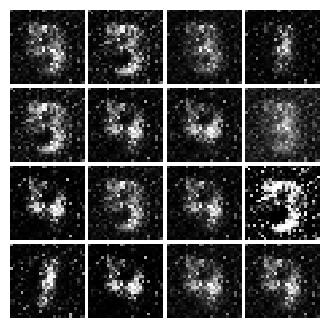


Iter: 750, D: 0.5679, G:1.246


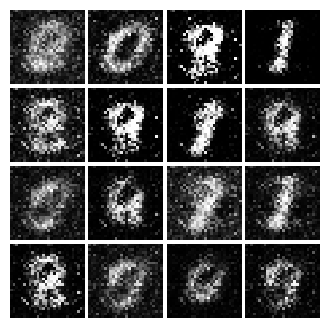


EPOCH:  3
Iter: 1000, D: 0.5302, G:1.209


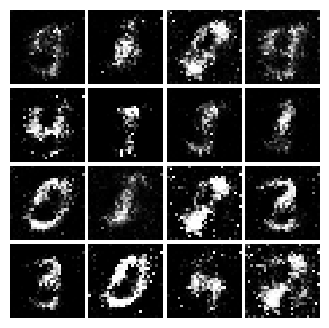


Iter: 1250, D: 0.4834, G:2.057


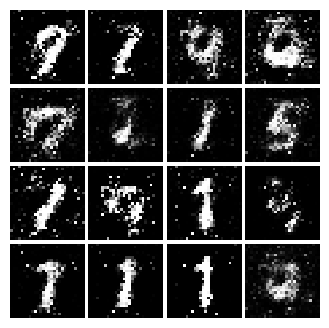


EPOCH:  4
Iter: 1500, D: 0.5447, G:0.9386


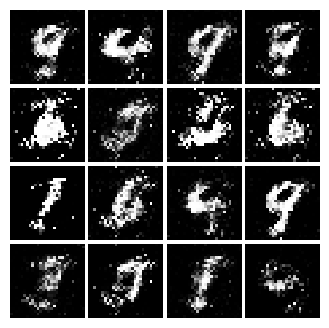


Iter: 1750, D: 1.128, G:2.653


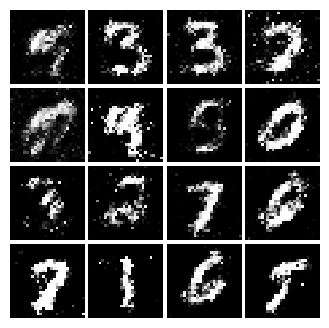


EPOCH:  5
Iter: 2000, D: 0.5664, G:0.9094


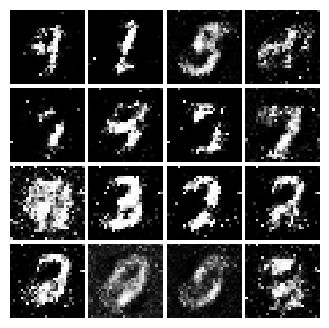


Iter: 2250, D: 0.6896, G:0.8303


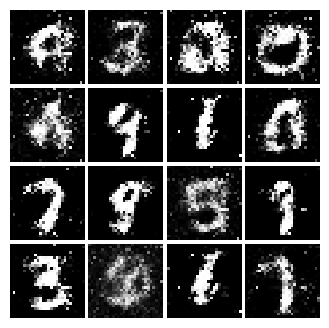


EPOCH:  6
Iter: 2500, D: 0.6148, G:0.8717


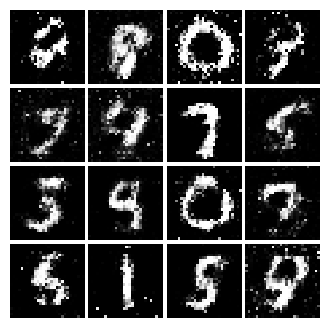


Iter: 2750, D: 0.6688, G:0.8496


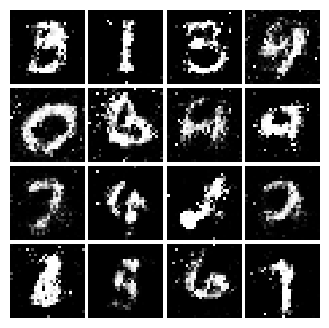


EPOCH:  7
Iter: 3000, D: 0.5534, G:0.963


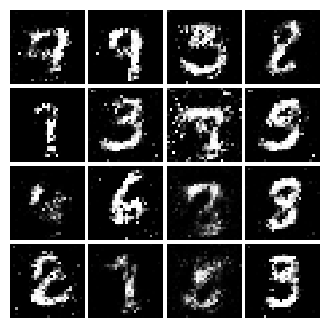


Iter: 3250, D: 0.5821, G:0.9875


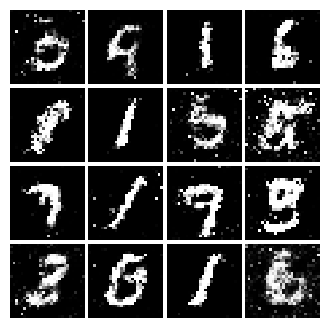


EPOCH:  8
Iter: 3500, D: 0.6727, G:0.8692


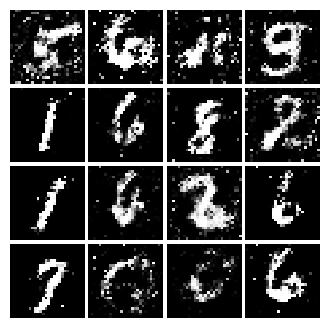


EPOCH:  9
Iter: 3750, D: 0.6487, G:0.8484


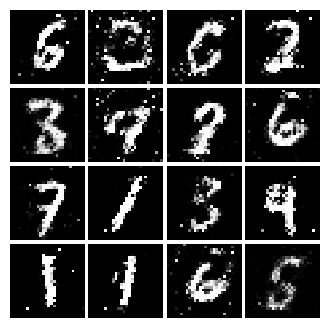


Iter: 4000, D: 0.7373, G:0.7864


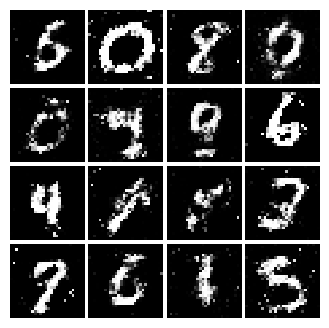


EPOCH:  10
Iter: 4250, D: 0.6247, G:0.8881


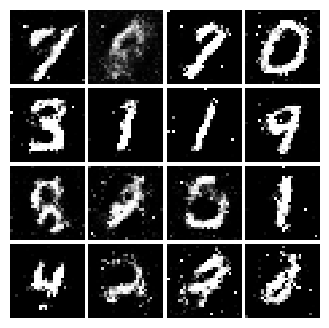


Iter: 4500, D: 0.664, G:0.871


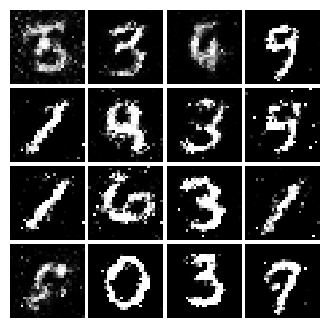

In [12]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.4425, G:0.4191


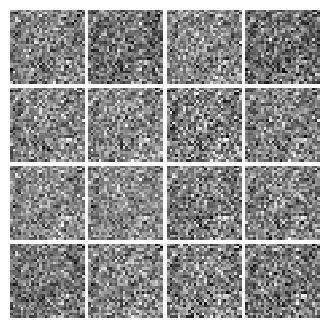


Iter: 250, D: 0.1731, G:0.238


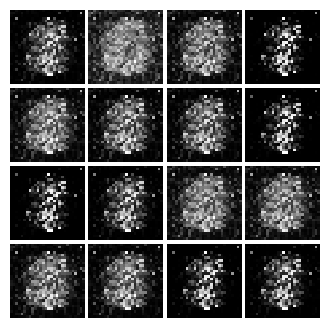


EPOCH:  2
Iter: 500, D: 0.2492, G:0.2078


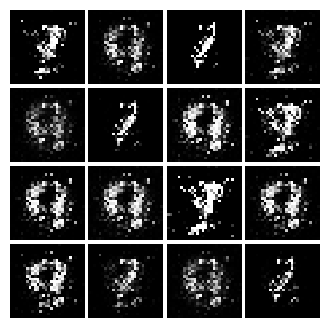


Iter: 750, D: 0.2995, G:0.4742


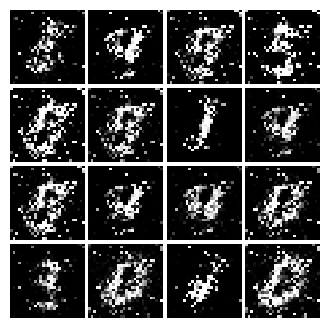


EPOCH:  3
Iter: 1000, D: 0.1918, G:0.2598


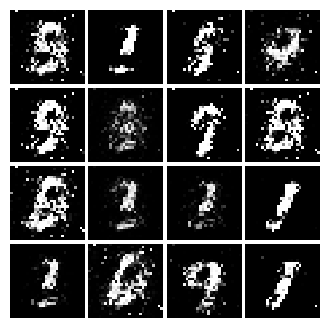


Iter: 1250, D: 0.1398, G:0.3847


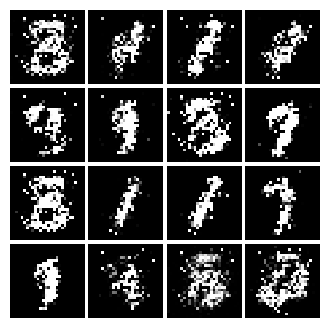


EPOCH:  4
Iter: 1500, D: 0.1215, G:0.8831


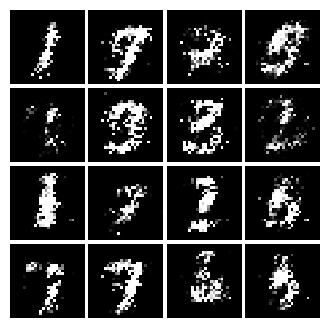


Iter: 1750, D: 0.1518, G:0.2915


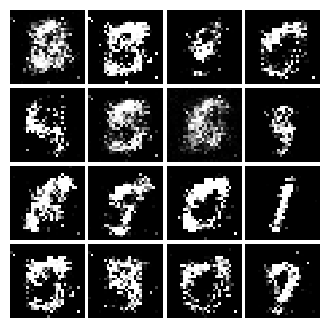


EPOCH:  5
Iter: 2000, D: 0.204, G:0.1494


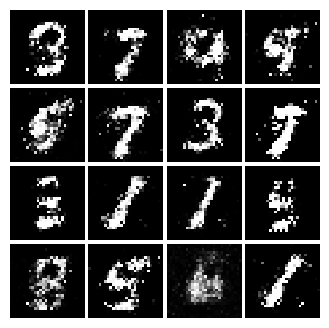


Iter: 2250, D: 0.2185, G:0.1971


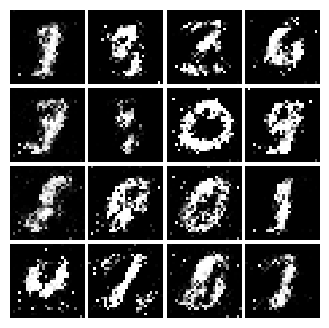


EPOCH:  6
Iter: 2500, D: 0.2087, G:0.2309


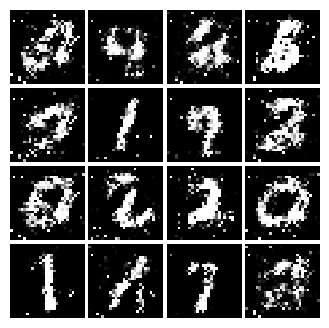


Iter: 2750, D: 0.2531, G:0.1792


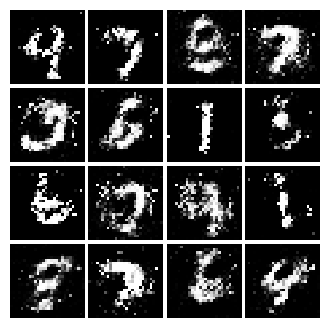


EPOCH:  7
Iter: 3000, D: 0.2232, G:0.164


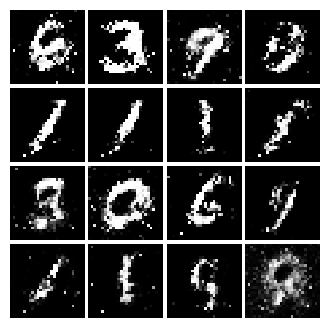


Iter: 3250, D: 0.1996, G:0.1672


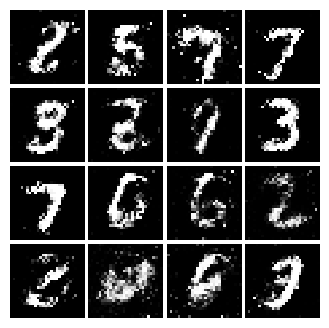


EPOCH:  8
Iter: 3500, D: 0.2316, G:0.1687


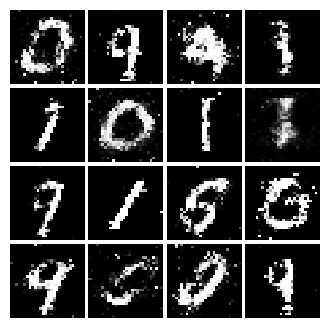


EPOCH:  9
Iter: 3750, D: 0.2247, G:0.1863


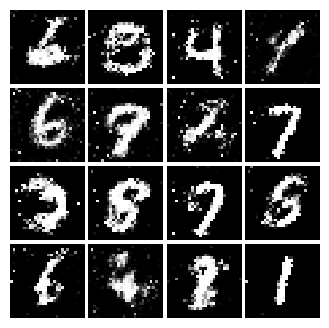


Iter: 4000, D: 0.2353, G:0.1542


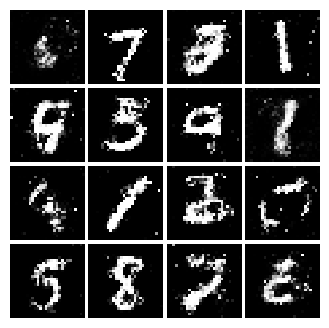


EPOCH:  10
Iter: 4250, D: 0.2288, G:0.1924


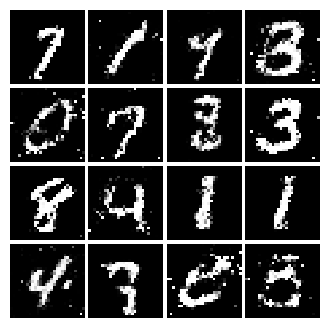


Iter: 4500, D: 0.2372, G:0.1549


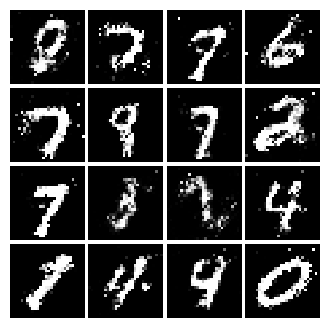

In [14]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)